## Part 1

### Loading the datasets
#### 1. Confirmed URL : https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv
#### 2. Deaths URL: https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv
#### 3. Recovered URL: https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv

#### Starting date on all three datasets is 22/01/2020

Steps (Without BeautifulSoup):-
1. Import the CSV 
2. Check if the last column title matches with the last date row in the cleaned dataset.
3. If it matches, don't add it to the dataset. 
4. If it does not match, go back iteratively until it matches and save all of the data.


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
import requests
from bs4 import BeautifulSoup

In [20]:
confirmed_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
deaths_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
recovered_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"

### Function to get the number of confirmed cases as a Dataframe

In [21]:
def get_confirmed():
    con_casesnew = pd.read_csv(confirmed_url)
    con_casesnew = con_casesnew.sum(axis=0)
    con_casesnew.drop(["Country/Region","Lat","Long"], axis=0, inplace=True)
    con_casesnew = pd.DataFrame(con_casesnew)
    con_casesnew.rename(columns={0: "Infected"}, inplace=True)
    return con_casesnew

### Function to get the number of deaths as a Dataframe

In [22]:
def get_deaths():
    deaths_new = pd.read_csv(deaths_url)
    deaths_new = deaths_new.sum(axis=0)
    deaths_new.drop(["Country/Region","Lat","Long"], axis=0, inplace=True)
    deaths_new = pd.DataFrame(deaths_new)
    deaths_new.rename(columns={0: "Deaths"}, inplace=True)
    return deaths_new

### Function to get the number of recoveries as a Dataframe

In [23]:
def get_recovered():
    rec_new = pd.read_csv(confirmed_url)
    rec_new = rec_new.sum(axis=0)
    rec_new.drop(["Country/Region","Lat","Long"], axis=0, inplace=True)
    rec_new = pd.DataFrame(rec_new)
    rec_new.rename(columns={0: "Recovered"}, inplace=True)
    
    return rec_new

### Scraper

In [24]:
def get_newvals():
    url_wminfo = "https://www.worldometers.info/coronavirus/"
    page = requests.get(url_wminfo)
    soup = BeautifulSoup(page.content, 'html.parser')
    result = soup.find_all("div", {"id":"maincounter-wrap"})
    numbers = []
    for r in result:
        numbers.append(int(r.text.split(':')[-1].replace(',','').replace(' ','')))
    return numbers

In [25]:
numbers = get_newvals()
numbers

[886112, 44228, 185274]

### Fixing the dates column

In [26]:
# def_nextdate():
    

## Forecasting Confirmed Cases

In [27]:
df = get_confirmed()

In [28]:
df.tail()

,Infected
3/27/20,593291
3/28/20,660706
3/29/20,720117
3/30/20,782365
3/31/20,857487


In [29]:
close_data = df['Infected'].values
close_data = close_data.reshape((-1,1))

split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

cclose = close_data

In [30]:
look_back = 2

train_generator = TimeseriesGenerator(cclose, cclose, length=look_back, batch_size=20)     
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [31]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(
    LSTM(10,
        activation='relu',
        input_shape=(look_back,1))
)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

num_epochs = 100
model.fit_generator(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/100
4/4 [==============================] - 2s 492ms/step - loss: 35206759150.3059
Epoch 2/100
4/4 [==============================] - 0s 12ms/step - loss: 34799289910.9647
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 33704652734.4941
Epoch 4/100
4/4 [==============================] - 0s 18ms/step - loss: 33259546494.4941
Epoch 5/100
4/4 [==============================] - 0s 21ms/step - loss: 32291868193.8824
Epoch 6/100
4/4 [==============================] - 0s 15ms/step - loss: 31532799301.2706
Epoch 7/100
4/4 [==============================] - 0s 19ms/step - loss: 30946369412.5176
Epoch 8/100
4/4 [==============================] - 0s 21ms/step - loss: 30183973113.2235
Epoch 9/100
4/4 [==============================] - 0s 20ms/step - loss: 29152333805.9294
Epoch 10/100
4/4 [==============================] - 0s 17ms/step - loss: 28445846853.2706
Epoch 11/100
4/4 [==============================] - 0s 19ms/step - loss: 27881360097.1294
Epoch 12/100
4/4 [

In [32]:
prediction = model.predict_generator(test_generator)

cclose = cclose.reshape((-1))
close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

In [33]:
close_data = close_data.reshape((-1))

def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
num_prediction = 1
forecast = predict(num_prediction, model)
forecast = numbers[0]

In [34]:
forecast

886112

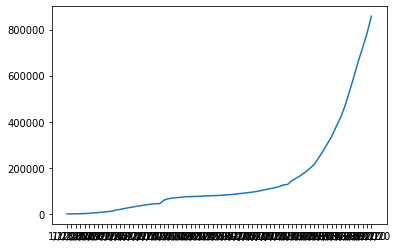

In [35]:
plt.plot(df)

In [36]:
df.tail()

,Infected
3/27/20,593291
3/28/20,660706
3/29/20,720117
3/30/20,782365
3/31/20,857487


In [37]:
forecast

886112

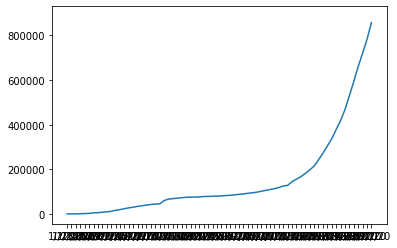

In [38]:
plt.plot(df)
plt.plot(forecast)

In [39]:
type(df.index)

pandas.core.indexes.base.Index

In [40]:
df.tail()

,Infected
3/27/20,593291
3/28/20,660706
3/29/20,720117
3/30/20,782365
3/31/20,857487


In [41]:
df.tail(10)

,Infected
3/22/20,336953
3/23/20,378235
3/24/20,418045
3/25/20,467653
3/26/20,529591
3/27/20,593291
3/28/20,660706
3/29/20,720117
3/30/20,782365
3/31/20,857487
